# Functions

## Imports

In [2]:
from pySimFinLIB import pySimFin
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, normaltest, norm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, probplot

psf = pySimFin()

In [3]:
import streamlit as st

# Sidebar range slider
min_value, max_value = st.sidebar.slider("Select a range", 1, 100, (25, 75))

# Display the selected min and max values
st.write(f"Minimum selected value: {min_value}")
st.write(f"Maximum selected value: {max_value}")

2025-03-18 17:38:51.083 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 17:38:51.083 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 17:38:51.083 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 17:38:51.084 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 17:38:51.158 
  command:

    streamlit run /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-18 17:38:51.158 Thread 'MainThread': missing ScriptRunConte

## Data Loading

In [4]:
companyName = 'AAPL'

list([companyName])

['AAPL']

## Modelling

In [5]:
def calcColumns(df):
    df['Log_Return'] = (np.log(df['Close'] / df['Close'].shift(1))*100)
    df.dropna(inplace=True)

    # Compute absolute log-returns
    df['Abs_Log_Return'] = np.abs(df['Log_Return'])

    # Compute rolling 60-day standard deviation
    df['Rolling_Std'] = df['Log_Return'].rolling(window=60).std()

    # LOESS smoothing (LOWESS from statsmodels)
    lowess = sm.nonparametric.lowess
    global smoothed_abs
    smoothed_abs = lowess(df['Abs_Log_Return'], df.index, frac=0.03)  # frac=0.03 controls smoothness

def plotTSandLR(df, smoothed_abs):
    # Plot time series
    fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

    fCompany = f"{', '.join(company.capitalize() for company in companies)}"

    # Plot log-returns
    top_ax = axes[0]
    top_ax.plot(df.index, df['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
    top_ax.set_ylabel("Log-Returns (%)")
    top_ax.set_title(f"{fCompany} Log-Returns (2019-2024)")
    top_ax.legend()

    # Plot absolute log-returns with LOESS and rolling std
    bottom_ax = axes[1]
    bottom_ax.plot(df.index, df['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
    bottom_ax.plot(df.index, df['Rolling_Std'], color='red', label='60-Day Rolling Std')
    bottom_ax.plot(df.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
    bottom_ax.set_ylabel("Absolute Log-Returns (%)")
    bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2019-2024)")
    bottom_ax.legend()

    plt.tight_layout()
    plt.show()

## Fitting Normal Distribution

In [6]:


def fitNormalDist(df):
    # Compute statistics
    mean_return = np.mean(df['Log_Return'])
    variance_return = np.var(df['Log_Return'])
    skewness_return = skew(df['Log_Return'])
    kurtosis_return = kurtosis(df['Log_Return'])

    # Normality test (D'Agostino and Pearson’s test)
    stats_test, p_value = normaltest(df['Log_Return'])
    normality_result = "Normal" if p_value > 0.05 else "Not Normal"

    fCompany = f"{', '.join(company.capitalize() for company in companies)}"

    # Print statistics
    print(f"Mean: {mean_return:.4f}")
    print(f"Variance: {variance_return:.4f}")
    print(f"Skewness: {skewness_return:.4f}")
    print(f"Kurtosis: {kurtosis_return:.4f}")
    print(f"Normality Test p-value: {p_value:.4f} ({normality_result})")

    # Plot histogram with overlaid normal distribution
    plt.figure(figsize=(10, 5))
    count, bins, _ = plt.hist(df['Log_Return'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

    # Compute normal distribution curve
    x = np.linspace(bins[0], bins[-1], 100)
    pdf = norm.pdf(x, mean_return, np.sqrt(variance_return))
    plt.plot(x, pdf, color='red', lw=2, label=f'Normal Dist (μ={mean_return:.2f}, σ²={variance_return:.2f})')

    plt.xlabel("Log-Returns (%)")
    plt.ylabel("Density")
    plt.title(f"Histogram of {fCompany} Log-Returns (2019-2024) with Normal Distribution")
    plt.legend()
    plt.grid()
    plt.show()

## Fitting T-Distribution

In [7]:
from scipy.stats import t
def fitTDist(df):
    # Fit a t-distribution to the log-returns
    params = t.fit(df['Log_Return'])  # Direct fitting

    # Extract fitted parameters
    df_t, loc_t, scale_t = params

    # Compute variance and kurtosis of the fitted t-distribution
    variance_t = (df_t / (df_t - 2)) * (scale_t ** 2) if df_t > 2 else np.nan
    kurtosis_t = (6 / (df_t - 4)) if df_t > 4 else np.inf  # Infinite for df <= 4

    fCompany = f"{', '.join(company.capitalize() for company in companies)}"

    # Print fitted parameters and statistics
    print(f"Fitted t-distribution parameters:")
    print(f"Degrees of Freedom: {df_t:.4f}")
    print(f"Location: {loc_t:.4f}")
    print(f"Scale: {scale_t:.4f}")
    print(f"Variance: {variance_t:.4f}")
    print(f"Kurtosis: {'Infinite' if np.isinf(kurtosis_t) else f'{kurtosis_t:.4f}'}")

    # Plot histogram with normal and t-distribution curves
    plt.figure(figsize=(10, 5))
    count, bins, _ = plt.hist(df['Log_Return'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

    # Compute normal and t-distribution curves
    x = np.linspace(bins[0], bins[-1], 100)
    pdf_norm = norm.pdf(x, np.mean(df['Log_Return']), np.std(df['Log_Return']))
    pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

    plt.plot(x, pdf_norm, color='red', lw=2, label=f'Normal Dist (μ={np.mean(df["Log_Return"]):.2f}, σ²={np.var(df["Log_Return"]):.2f})')
    plt.plot(x, pdf_t, color='green', lw=2, label=f't-Dist (df={df_t:.2f}, scale={scale_t:.2f})')

    plt.xlabel("Log-Returns (%)")
    plt.ylabel("Density")
    plt.title(f"Histogram of {fCompany} Log-Returns with Normal and t-Distributions")
    plt.legend()
    plt.grid()
    plt.show()


## GARCH Model

In [8]:
def fitGARCH(df):
    # Prepare the data
    global returns
    returns = df['Log_Return'].dropna()

    # Fit GARCH(1,1) model with t-distributed errors
    garch_model = arch_model(returns, mean = 'AR', lags= 1, vol='Garch', p=1, o=0, q=1, dist='t')
    global garch_fit
    garch_fit = garch_model.fit(disp='off')
    print("\nModel Summary:")
    print(garch_fit.summary())

    # Plot GJR-GARCH model results
    fig = garch_fit.plot()

## Visualise Volatility

In [9]:
def visVolatility(returns, garch_fit):
    # Get the conditional volatility (sigma_t) and standardized residuals
    conditional_volatility = garch_fit.conditional_volatility
    absolute_log_returns = np.abs(returns)

    # Combined plot with two subplots stacked vertically
    fig, axs = plt.subplots(2, 1, figsize=(14, 12))

    # Plot 1: Log returns with shaded ±2 conditional standard deviations
    axs[0].plot(returns, label='Log Returns', color='blue')
    upper_bound = 2 * conditional_volatility
    lower_bound = -2 * conditional_volatility
    axs[0].fill_between(df.index, lower_bound, upper_bound, color='red', alpha=0.2, label='±2 Conditional Std Dev')
    axs[0].set_title('Log Returns with Conditional Std Deviations (Shaded ±2σ)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Log Returns / Volatility')
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: Conditional Std Dev vs. Absolute Log Returns
    axs[1].plot(absolute_log_returns, label='|Log Returns|', color='gray', alpha=0.2)
    axs[1].plot(conditional_volatility, label='Conditional Std Dev (GARCH)', color='red')
    axs[1].set_title('Conditional Std Dev vs Absolute Log Returns')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Values')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.show()


## Residual Analysis

In [10]:
def residualAnalysis(garch_fit):
    # Compute standardized residuals
    std_residuals = garch_fit.resid / garch_fit.conditional_volatility
    std_residuals = std_residuals.dropna()

    # Set up 2x2 residual plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Standardized residual time series
    sns.lineplot(x=std_residuals.index, y=std_residuals, ax=axes[0, 0], color='blue')
    axes[0, 0].set_title("Standardized Residuals Time Series")
    axes[0, 0].set_ylabel("Standardized Residuals")
    axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.6)

    # 2. ACF of standardized residuals
    plot_acf(std_residuals, ax=axes[0, 1], lags=40)
    axes[0, 1].set_title("ACF of Standardized Residuals")

    # 3. ACF of squared standardized residuals
    plot_acf(std_residuals**2, ax=axes[1, 0], lags=40)
    axes[1, 0].set_title("ACF of Squared Standardized Residuals")

    # 4. QQ-plot with estimated t-distribution
    df_t, loc_t, scale_t = t.fit(std_residuals)
    x = np.linspace(min(std_residuals), max(std_residuals), 100)
    pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

    axes[1, 1].hist(std_residuals, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black', label="Residuals")
    axes[1, 1].plot(x, pdf_t, color='red', lw=2, label=f't-Dist (df={df_t:.2f})')
    axes[1, 1].set_title("Histogram of Standardized Residuals with t-Distribution")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


## Risk Modelling - VaR Estimates

In [11]:
def VaR(df):
    # Prepare the data
    returns = df['Log_Return'].dropna()

    # Confidence levels for VaR
    global confidence_levels
    confidence_levels = np.linspace(0.975, 0.9999, 100)

    # Compute VaR for different confidence levels
    global VaR_hist, VaR_norm, VaR_t
    VaR_hist = [np.percentile(returns, (1 - alpha) * 100) for alpha in confidence_levels]
    VaR_norm = [norm.ppf(1 - alpha, loc=np.mean(returns), scale=np.std(returns)) for alpha in confidence_levels]
    global df_t, loc_t, scale_t
    df_t, loc_t, scale_t = t.fit(returns)
    VaR_t = [loc_t + scale_t * t.ppf(1 - alpha, df_t) for alpha in confidence_levels]

    # Plot VaR estimates as a function of confidence level
    plt.figure(figsize=(10, 6))
    plt.plot(confidence_levels * 100, VaR_hist, label='Historical VaR', linestyle='dashed', color='black')
    plt.plot(confidence_levels * 100, VaR_norm, label='Normal VaR', linestyle='dotted', color='red')
    plt.plot(confidence_levels * 100, VaR_t, label='t-Distribution VaR', linestyle='solid', color='green')

    plt.xlabel("Confidence Level (%)")
    plt.ylabel("Log-Returns")
    plt.title("Bitcoin VaR Estimates Across Confidence Levels")
    plt.legend()
    plt.grid()
    plt.show()

## Expected Shortfall

In [12]:
def expectedShortfall(confidence_levels):
    # Compute Expected Shortfall (ES) using the proper formulas
    mean_return, std_return = returns.mean(), returns.std()
    phi_norm = norm.pdf(norm.ppf(confidence_levels))
    ES_norm = mean_return - std_return * (phi_norm / (1 - confidence_levels))

    # Compute t-Distribution Expected Shortfall
    t_alpha = t.ppf(confidence_levels, df_t)
    t_pdf_alpha = t.pdf(t_alpha, df_t)
    ES_t = loc_t - scale_t * (t_pdf_alpha / (1 - confidence_levels)) * (df_t + t_alpha**2) / (df_t - 1)

    # Compute Historical Expected Shortfall (ES) directly from data
    ES_hist = [returns[returns <= VaR_hist[i]].mean() for i in range(len(confidence_levels))]

    # Plot Expected Shortfall (ES) estimates as a function of confidence level
    plt.figure(figsize=(10, 6))
    plt.plot(confidence_levels * 100, ES_hist, label='Historical ES', linestyle='dashed', color='black')
    plt.plot(confidence_levels * 100, ES_norm, label='Normal ES', linestyle='dotted', color='red')
    plt.plot(confidence_levels * 100, ES_t, label='t-Distribution ES', linestyle='solid', color='green')
    plt.xlabel("Confidence Level (%)")
    plt.ylabel("Log-Returns")
    plt.title("Bitcoin Expected Shortfall (ES) Estimates Across Confidence Levels")
    plt.legend()
    plt.grid()
    plt.show()

## Dynamic risk modelling

In [13]:
def dynamicRM(garch_fit):
    # Extract conditional volatility and standardized residuals
    std_residuals = garch_fit.resid / garch_fit.conditional_volatility
    std_residuals = std_residuals.dropna()
    cond_volatility = garch_fit.conditional_volatility.dropna()

    # Fit t-distribution to standardized residuals
    df_t, loc_t, scale_t = t.fit(std_residuals)

    # Compute dynamic VaR at 95% and 99%
    VaR_95 = -scale_t * t.ppf(0.05, df_t) * cond_volatility
    VaR_99 = -scale_t * t.ppf(0.01, df_t) * cond_volatility

    # Plot time series of negative log-returns with dynamic VaR
    plt.figure(figsize=(12, 6))
    plt.plot(-returns, label="Negative Log-Returns", color='blue', alpha=0.6)
    plt.plot(VaR_95, label="95% Dynamic VaR", linestyle='dashed', color='red')
    plt.plot(VaR_99, label="99% Dynamic VaR", linestyle='solid', color='black')

    plt.xlabel("Date")
    plt.ylabel("Log-Returns")
    plt.title("Bitcoin Negative Log-Returns with Dynamic VaR Estimates")
    plt.legend()
    plt.grid()
    plt.show()

# Execution

In [ ]:
df = 

In [14]:
calcColumns(df)

NameError: name 'df' is not defined

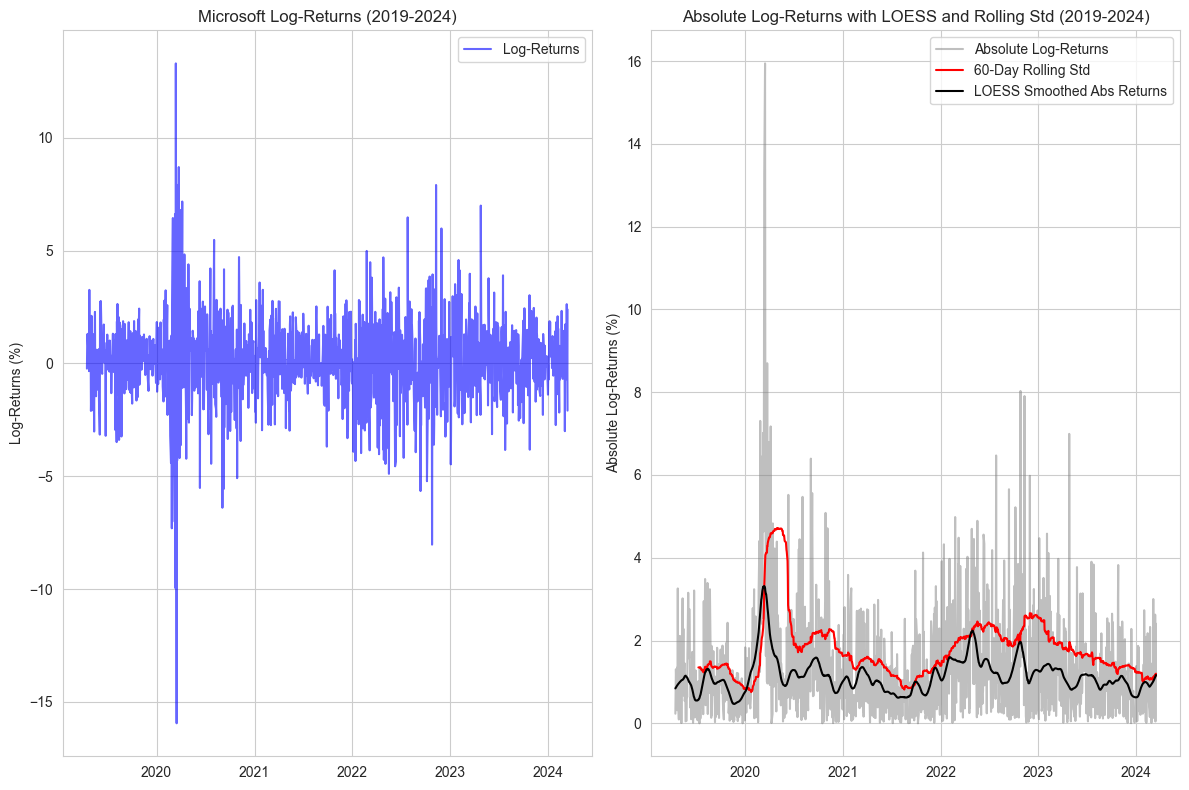

In [16]:
plotTSandLR(df, smoothed_abs)

Mean: 0.0998
Variance: 3.7146
Skewness: -0.2714
Kurtosis: 7.4815
Normality Test p-value: 0.0000 (Not Normal)


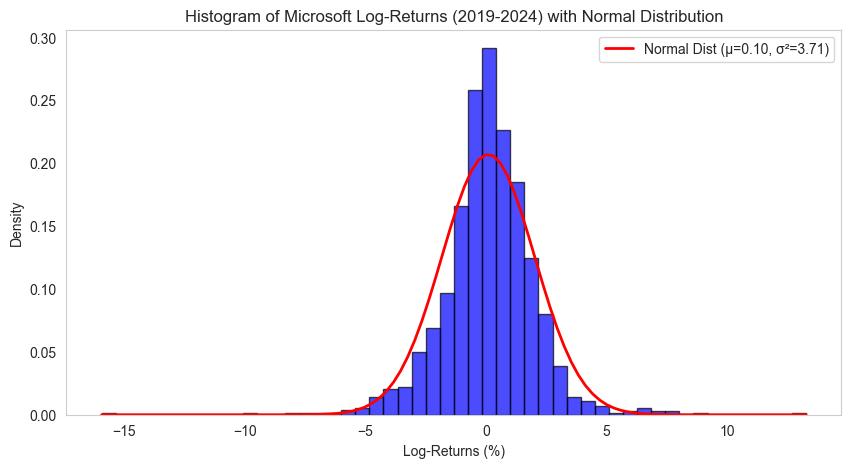

In [17]:
fitNormalDist(df)

Fitted t-distribution parameters:
Degrees of Freedom: 3.7988
Location: 0.1324
Scale: 1.3389
Variance: 3.7858
Kurtosis: Infinite


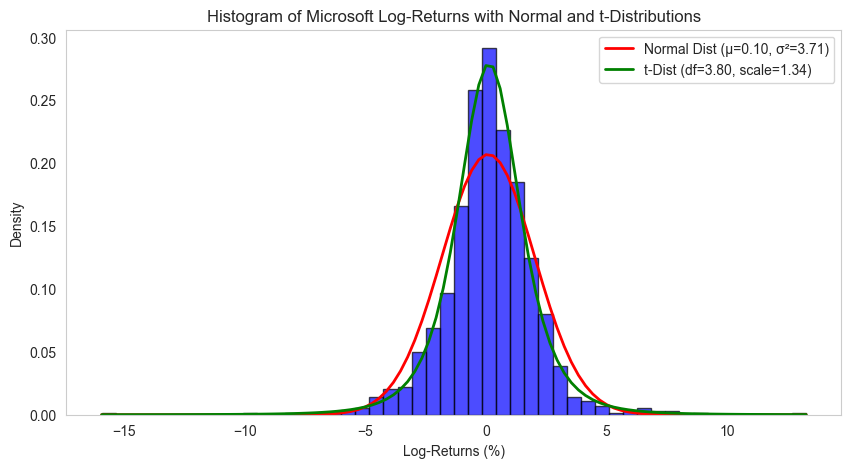

In [18]:
fitTDist(df)


Model Summary:
                              AR - GARCH Model Results                              
Dep. Variable:                   Log_Return   R-squared:                       0.020
Mean Model:                              AR   Adj. R-squared:                  0.019
Vol Model:                            GARCH   Log-Likelihood:               -2373.55
Distribution:      Standardized Student's t   AIC:                           4759.09
Method:                  Maximum Likelihood   BIC:                           4789.81
                                              No. Observations:                 1237
Date:                      Wed, Mar 12 2025   Df Residuals:                     1235
Time:                              21:48:39   Df Model:                            2
                                  Mean Model                                  
                    coef    std err          t      P>|t|     95.0% Conf. Int.
-------------------------------------------------------------

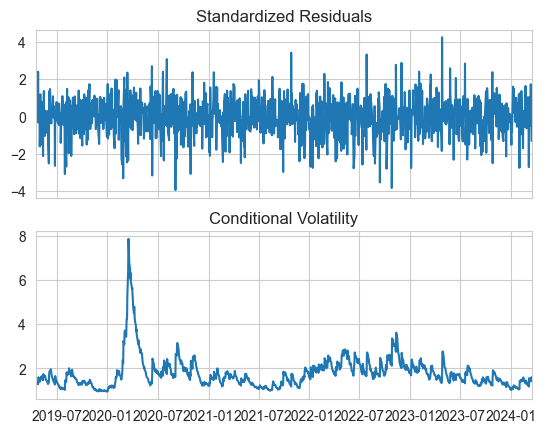

In [19]:
fitGARCH(df)


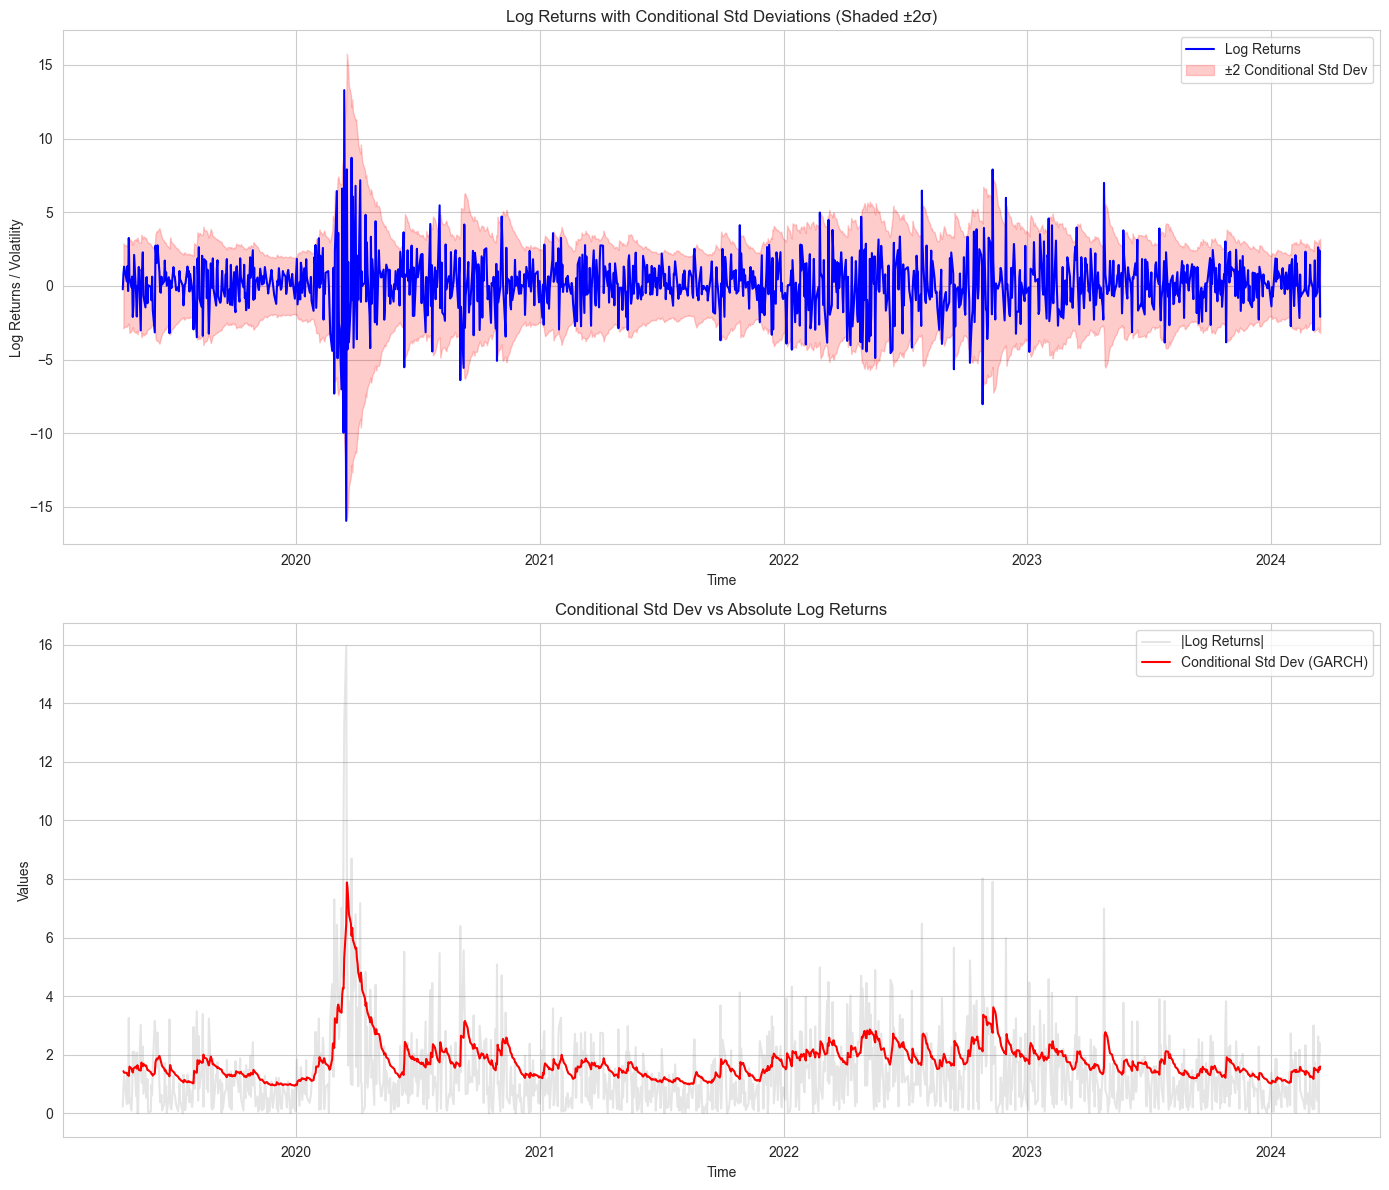

In [20]:
visVolatility(returns, garch_fit)

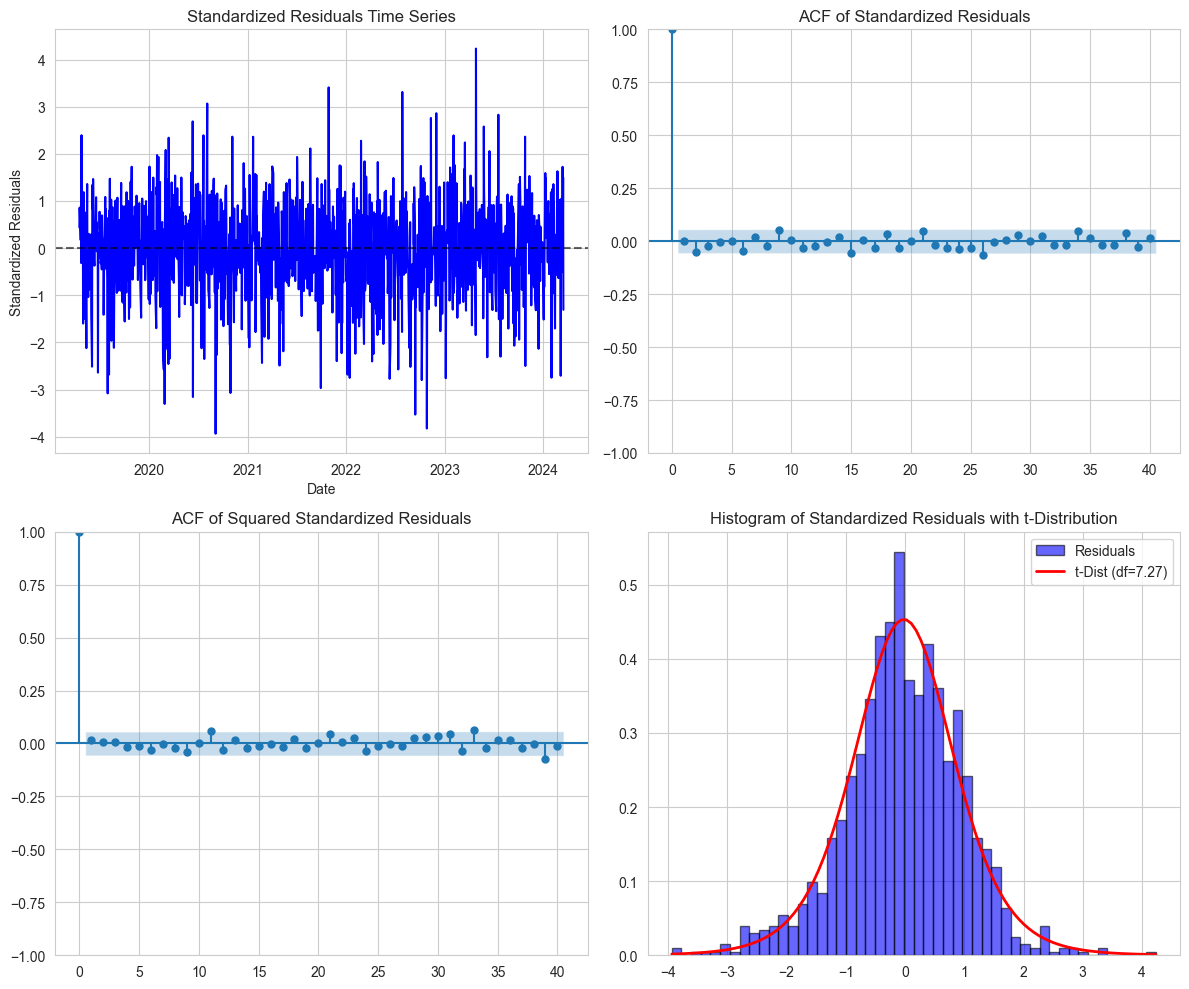

In [21]:
residualAnalysis(garch_fit)

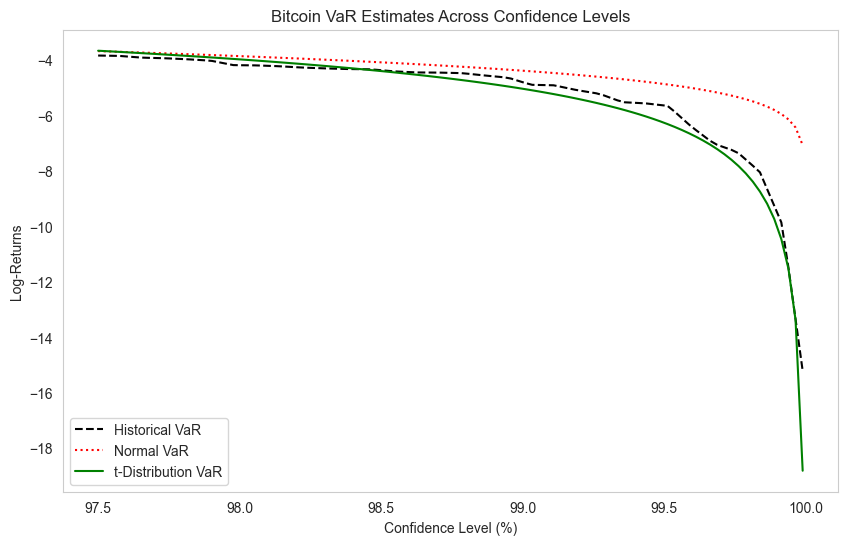

In [22]:
VaR(df)

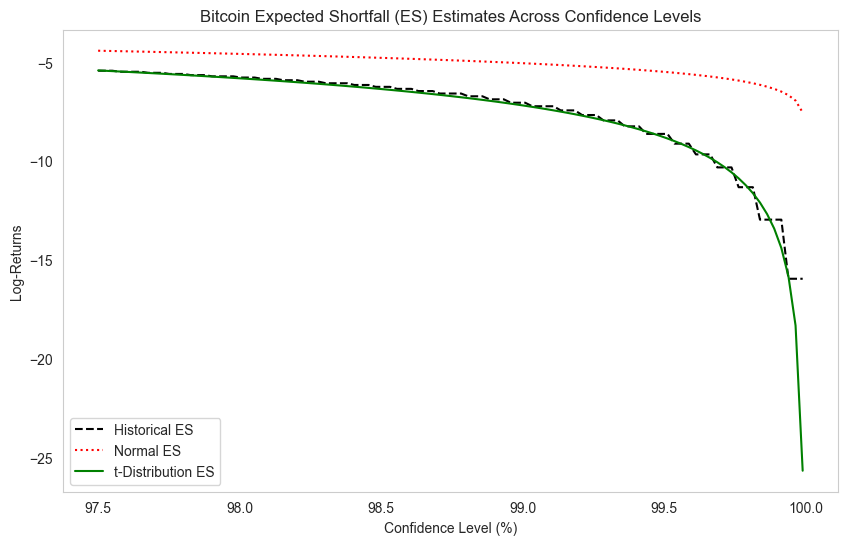

In [23]:
expectedShortfall(confidence_levels)

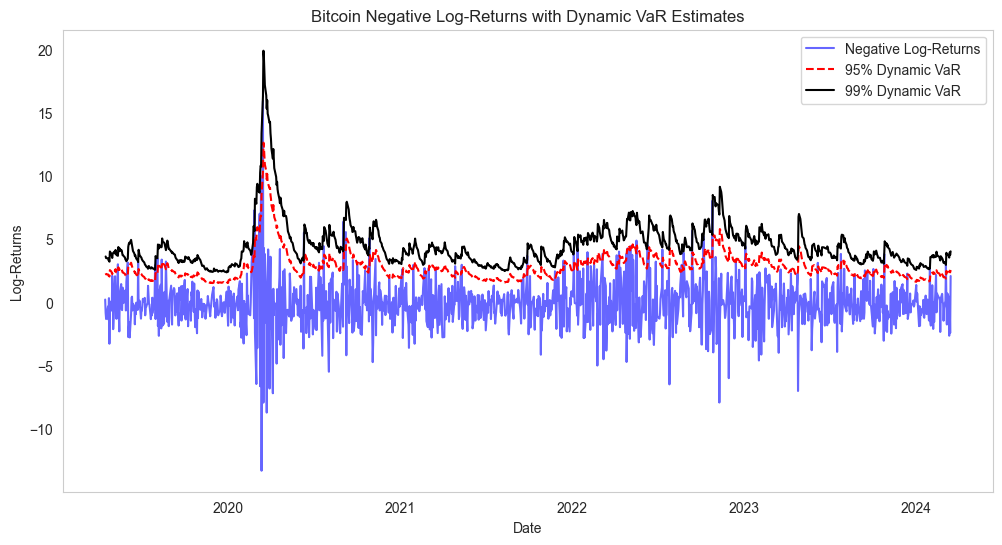

In [24]:
dynamicRM(garch_fit)

# CompaniesTest

In [7]:
from pySimFinLib import pySimFin
psf = pySimFin()

companies = ['microsoft']
start_date = '2018-01-01'
end_date = '2020-01-01'


In [8]:
psf.get_financial_statement(companies, start_date, end_date)

Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/simfin/load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
MSFT   2019-06-30      59265      USD         2019            Q4   2019-08-01   
       2019-09-30      59265      USD         2020            Q1   2019-10-23   
       2019-12-31      59265      USD         2020            Q2   2020-01-29   

                   Restated Date  Shares (Basic)  Shares (Diluted)  \
Ticker Report Date                                                   
MSFT   2019-06-30     2021-07-29    7.655000e+09      7.734000e+09   
       2019-09-30     2020-10-27    7.634000e+09      7.710000e+09   
       2019-12-31     2021-01-26    7.621000e+09      7.691000e+09   

                         Revenue  Cost of Revenue  ...  \
Ticker Report Date                                 ...   
MSFT   2019-06-30   3.371700e+10    -1.041200e+10  ...   
       2019-09-30   3.305500e+10    -1.040600e+10  ...   
       2019-12-31   3.690600e+10    -1.235800e+10  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
MSFT   2019-06-30                   191000000.0             39944953.0   
       2019-09-30                           0.0             86925446.0   
       2019-12-31                   194000000.0             34048124.0   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
MSFT   2019-06-30                 1.259600e+10                      NaN   
       2019-09-30                 1.268600e+10                      NaN   
       2019-12-31                 1.408500e+10                      NaN   

                    Pretax Income (Loss)  Income Tax (Expense) Benefit, Net  \
Ticker Report Date                                                            
MSFT   2019-06-30            12596000000                       5.910000e+08   
       2019-09-30            12686000000                      -2.008000e+09   
       2019-12-31            14085000000                      -2.436000e+09   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
MSFT   2019-06-30                                13187000000   
       2019-09-30                                10678000000   
       2019-12-31                                11649000000   

                    Net Extraordinary Gains (Losses)   Net Income  \
Ticker Report Date                                                  
MSFT   2019-06-30                                NaN  13187000000   
       2019-09-30                                NaN  10678000000   
       2019-12-31                                NaN  11649000000   

                    Net Income (Common)  
Ticker Report Date                       
MSFT   2019-06-30           13187000000  
       2019-09-30           10678000000  
       2019-12-31           11649000000  

[3 rows x 26 columns]

In [9]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd


def getCompanyInfo(ticker):
    load_dotenv()
    API_KEY = os.getenv('API_KEY')

    headers = {
        "accept": "application/json",
        "Authorization": API_KEY
    }

    url = "https://backend.simfin.com/api/v3/companies/general/compact?ticker=" + ticker
    response = requests.get(url, headers=headers).json()

    return pd.DataFrame(response['data'], columns=response['columns'])

In [10]:
getCompanyInfo('LND')

,companyDescription,endFy,id,industryName,isin,market,name,numEmployees,sectorCode,sectorName,ticker
0,BrasilAgro - Companhia Brasileira de Proprieda...,12,17797923,Consumer Defensive,US10554B1044,US,BrasilAgro - Companhia Brasileira de Proprieda...,None,102002,Consumer Packaged Goods,LND


In [43]:
psf = pySimFin()

In [6]:
psf.getCompanyInfo('AAPL')

,companyDescription,endFy,id,industryName,isin,market,name,numEmployees,sectorCode,sectorName,ticker
0,Apple Inc is an American multinational technol...,9,111052,Technology,US0378331005,US,APPLE INC,147000,101001,Computer Hardware,AAPL


In [25]:
import requests
from dotenv import load_dotenv
import os

def getStockPrices(ticker, start_date, end_date):
    load_dotenv()
    API_KEY = os.getenv('API_KEY')
    
    url = f"https://backend.simfin.com/api/v3/companies/prices/compact?ticker={ticker}&start={start_date}&end={end_date}"

    headers = {
        "accept": "application/json",
        "Authorization": API_KEY
    }

    response = requests.get(url, headers=headers).json()

    return pd.DataFrame(response[0]['data'], columns=response[0]['columns'])
    #return pd.DataFrame(response)

getStockPrices('AAPL', '2019-01-01', '2024-01-01')




,Date,Dividend Paid,Common Shares Outstanding,Last Closing Price,Adjusted Closing Price,Highest Price,Lowest Price,Opening Price,Trading Volume
0,2019-01-02,NaN,18919212000,39.48,37.67,39.71,38.56,38.72,148158948
1,2019-01-03,NaN,18919212000,35.55,33.91,36.43,35.50,35.99,365248780
2,2019-01-04,NaN,18919212000,37.06,35.36,37.14,35.95,36.13,234428280
3,2019-01-07,NaN,18919212000,36.98,35.28,37.21,36.48,37.17,219111056
4,2019-01-08,NaN,18919212000,37.69,35.96,37.95,37.13,37.39,164101256
...,...,...,...,...,...,...,...,...,...
1253,2023-12-22,NaN,15744231000,193.60,192.45,195.41,192.97,195.18,37149570
1254,2023-12-26,NaN,15744231000,193.05,191.90,193.89,192.83,193.61,28919310
1255,2023-12-27,NaN,15744231000,193.15,192.00,193.50,191.09,192.49,47899806
1256,2023-12-28,NaN,15744231000,193.58,192.43,194.66,193.17,194.14,34049898


In [27]:
from psf2 import pySimFin2

psf2 = pySimFin2()

In [31]:
psf2.getCompanyInfo('AAPL')

,companyDescription,endFy,id,industryName,isin,market,name,numEmployees,sectorCode,sectorName,ticker
0,Apple Inc is an American multinational technol...,9,111052,Technology,US0378331005,US,APPLE INC,147000,101001,Computer Hardware,AAPL


In [30]:
psf2.getStockPrices('AAPL', '2019-01-01', '2025-01-01')['Date']

0       2019-01-02
1       2019-01-03
2       2019-01-04
3       2019-01-07
4       2019-01-08
           ...    
1505    2024-12-24
1506    2024-12-26
1507    2024-12-27
1508    2024-12-30
1509    2024-12-31
Name: Date, Length: 1510, dtype: object

In [39]:
import requests
from dotenv import load_dotenv
import os

def getCompanyList():
    load_dotenv()
    API_KEY = os.getenv('API_KEY')

    url = "https://backend.simfin.com/api/v3/companies/list"

    headers = {
        "accept": "application/json",
        "Authorization": API_KEY
    }

    response = requests.get(url, headers=headers).json()

    raw = pd.DataFrame(response)

    raw = raw[~raw['isin'].isna()]

    return raw

In [40]:
getCompanyList()

,id,name,ticker,sectorCode,industryName,sectorName,isin
0,1234791,STERLING BANCORP,STL,104002.0,Financial Services,Banks,US85917A1007
3,1253409,Infosys Ltd,INFY,101003.0,Technology,Application Software,US4567881085
4,1291790,ACCELERON PHARMA INC,XLRN,106001.0,Healthcare,Medical Diagnostics & Research,US00434H1086
42,65359,ALEXION PHARMACEUTICALS INC,ALXN,106002.0,Healthcare,Biotechnology,US0153511094
48,76840,"REMEDENT, INC.",REMI,106003.0,Healthcare,Medical Instruments & Equipment,US75954T1043
...,...,...,...,...,...,...,...
6210,18508051,Telefonaktiebolaget LM Ericsson (publ),ERIC,101005.0,Technology,Communication Equipment,US2948216088
6213,18515889,Ambev S.A.,ABEV,102004.0,Consumer Defensive,Beverages - Alcoholic,US02319V1035
6214,18515891,Avino Silver & Gold Mines Ltd.,ASM,110004.0,Basic Materials,Metals & Mining,CA0539061030
6216,18515895,CyberArk Software Ltd.,CYBR,101003.0,Technology,Application Software,IL0011334468


In [14]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd

def getCompanyListRaw():
    load_dotenv()
    API_KEY = os.getenv('API_KEY')

    url = "https://backend.simfin.com/api/v3/companies/list"

    headers = {
        "accept": "application/json",
        "Authorization": API_KEY
    }

    response = requests.get(url, headers=headers).json()

    return pd.DataFrame(response)


In [15]:
getCompanyListRaw()

,id,name,ticker,sectorCode,industryName,sectorName,isin
0,1234791,STERLING BANCORP,STL,104002.0,Financial Services,Banks,US85917A1007
1,1242008,NEVSUN RESOURCES LTD,NSU,NaN,None,None,None
2,1247792,Icanic Brands Co Inc.,PINX:ICNAF,NaN,None,None,None
3,1253409,Infosys Ltd,INFY,101003.0,Technology,Application Software,US4567881085
4,1291790,ACCELERON PHARMA INC,XLRN,106001.0,Healthcare,Medical Diagnostics & Research,US00434H1086
...,...,...,...,...,...,...,...
6213,18515889,Ambev S.A.,ABEV,102004.0,Consumer Defensive,Beverages - Alcoholic,US02319V1035
6214,18515891,Avino Silver & Gold Mines Ltd.,ASM,110004.0,Basic Materials,Metals & Mining,CA0539061030
6215,18515893,Alpha Tau Medical Ltd.,DRTS,106002.0,Healthcare,Biotechnology,None
6216,18515895,CyberArk Software Ltd.,CYBR,101003.0,Technology,Application Software,IL0011334468


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots: one for ACF and one for PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Generate the ACF plot for the 'index' column
plot_acf(df['index'], ax=ax[0])
ax[0].set_title("ACF Plot")

# Generate the PACF plot for the 'index' column
plot_pacf(df['index'], ax=ax[1])
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

In [2]:
def interpret_adf_test(test_statistic, p_value, critical_values):
    print(f"ADF Test Statistic: {test_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    # Check stationarity using p-value
    if p_value < 0.01:
        print("The p-value is less than 1%. Strong evidence against the null hypothesis (unit root present). The series is STATIONARY at 1% significance level.")
    elif p_value < 0.05:
        print("The p-value is less than 5%. Moderate evidence against the null hypothesis. The series is STATIONARY at 5% significance level.")
    elif p_value < 0.10:
        print("The p-value is less than 10%. Weak evidence against the null hypothesis. The series is STATIONARY at 10% significance level.")
    else:
        print("The p-value is greater than 10%. Fail to reject the null hypothesis. The series is NON-STATIONARY.")

    # Check stationarity using critical values
    for level, critical_value in critical_values.items():
        if test_statistic < critical_value:
            print(f"Test Statistic is below the {level}% critical value ({critical_value:.4f}). The series is STATIONARY at {level}% level.")
        else:
            print(f"Test Statistic is above the {level}% critical value ({critical_value:.4f}). The series is NOT stationary at {level}% level.")

# Example usage
test_statistic = -1.432
p_value = 0.5669
critical_values = {1: -3.4348, 5: -2.8635, 10: -2.5678}

adfDF = interpret_adf_test(test_statistic, p_value, critical_values)

ADF Test Statistic: -1.4320
p-value: 0.5669
The p-value is greater than 10%. Fail to reject the null hypothesis. The series is NON-STATIONARY.
Test Statistic is above the 1% critical value (-3.4348). The series is NOT stationary at 1% level.
Test Statistic is above the 5% critical value (-2.8635). The series is NOT stationary at 5% level.
Test Statistic is above the 10% critical value (-2.5678). The series is NOT stationary at 10% level.


In [28]:
ticker = 'AMZN'
start_date = '2019-01-01'
end_date = '2024-01-01'

from psf2 import pySimFin2
import ARCHLib

psf2obj = pySimFin2()

df = psf2obj.getStockPrices(ticker,start_date,end_date)
df = ARCHLib.calcColumns(df)

df

,Common Shares Outstanding,Last Closing Price,Adjusted Closing Price,Highest Price,Lowest Price,Opening Price,Trading Volume,Log_Return,Abs_Log_Return,Rolling_Std
Date,,,,,,,,,,
2019-01-03,9820000000,75.01,75.01,76.90,74.86,76.00,139511440,3.671858,3.671858,NaN
2019-01-04,9820000000,78.77,78.77,79.70,75.92,76.50,183651500,0.655740,0.655740,NaN
2019-01-07,9820000000,81.48,81.48,81.73,79.46,80.12,159864260,4.623477,4.623477,NaN
2019-01-08,9820000000,82.83,82.83,83.83,80.83,83.23,177628560,3.808235,3.808235,NaN
2019-01-09,9820000000,82.97,82.97,83.39,82.07,82.65,126976020,-0.699304,0.699304,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,10384615384,153.42,153.42,154.35,152.71,153.77,29514093,0.306119,0.306119,1.753675
2023-12-26,10384615384,153.41,153.41,153.97,153.03,153.56,25067222,-0.136661,0.136661,1.711614
2023-12-27,10384615384,153.34,153.34,154.78,153.12,153.56,31242664,0.000000,0.000000,1.706851


In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox

time_series = df['Log_Return']

def ljungboxTest(time_series):
    # Perform the Ljung-Box test for autocorrelation up to 10 lags
    numLags = len(time_series) ** (1/2)
    ljung_box_test = acorr_ljungbox(time_series, lags=[numLags], return_df=True)
    return ljung_box_test

ljungboxTest(time_series)

,lb_stat,lb_pvalue
35,33.784891,0.526681


In [39]:
from arch import arch_model



returns = df['Log_Return']


## ARCH Model
def fit_arch_model(returns):
    model = arch_model(returns, vol="ARCH", p=1)
    result = model.fit(disp="off")
    return result


## GARCH Model
def fit_garch_model(returns):
    model = arch_model(returns, vol="GARCH", p=1, q=1)
    result = model.fit(disp="off")
    return result

## GJR-GARCH Model
def fit_gjr_garch_model(returns):
    model = arch_model(returns, vol="GARCH", p=1, q=1, o=1)
    result = model.fit(disp="off")
    return result

## EGARCH Model
def fit_egarch_model(returns):
    model = arch_model(returns, vol="EGARCH", p=1, q=1)
    result = model.fit(disp="off")
    return result

In [40]:
fit_arch_model(returns)

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2797.20
Distribution:                  Normal   AIC:                           5600.39
Method:            Maximum Likelihood   BIC:                           5615.80
                                        No. Observations:                 1257
Date:                Mon, Mar 17 2025   Df Residuals:                     1256
Time:                        16:47:43   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0690  6.142e-02      1.123      0.261 [-5.13

In [ ]:
def modelChoice(comparison_df,):
    best_models = {
        "AIC": comparison_df["AIC"].idxmin(),  
        "BIC": comparison_df["BIC"].idxmin(), 
        "Log-Likelihood": comparison_df["Log-Likelihood"].idxmax() 
    }

    model_scores = comparison_df.index.to_series().apply(lambda x: sum(1 for metric in best_models.values() if metric == x))

    best_model = model_scores.idxmax()
    best_count = model_scores.max()

    # Decision logic
    if best_count == 3:
        st.write(f"🏆 {best_model} is the best model as it performs best in all three criteria.")
    elif best_count == 2:
        st.write(f"✅ {best_model} is the most favorable model, leading in 2 out of 3 criteria.")
    else:
        st.write("📊 No single model is the best in all criteria. Consider trade-offs:")
        for metric, best in best_models.items():
            st.write(f" - {metric}: {best}")

    # Display performance summary
    st.write("### Model Performance Summary")
    st.dataframe(comparison_df)

    # Highlight best models in each criterion
    highlight_df = comparison_df.copy()
    highlight_df["Best AIC"] = comparison_df.index == best_models["AIC"]
    highlight_df["Best BIC"] = comparison_df.index == best_models["BIC"]
    highlight_df["Best Log-Likelihood"] = comparison_df.index == best_models["Log-Likelihood"]

    st.write("### Best Model by Each Criterion")
    st.dataframe(highlight_df)

In [42]:
df = psf.getStockPrices(ticker,start_date,end_date)
df = ARCHLib.calcColumns(df)

NameError: name 'getStockPrices' is not defined

In [ ]:

"""Generate a business-friendly description of the GARCH model results"""
model_params = bestResult.params

# Retrieve model order (p, q)
volatility_model = bestResult.model.volatility  # Extract the volatility model
p = getattr(volatility_model, 'p', 0)  # Get p if it exists, otherwise default to 0
q = getattr(volatility_model, 'q', 0)  # Get q if it exists, otherwise default to 0

# Calculate persistence
persistence = sum([model_params.get(f'alpha[{i+1}]', 0) for i in range(p)] + 
                    [model_params.get(f'beta[{i+1}]', 0) for i in range(q)])

# Business-friendly interpretation
summary = "Our volatility model shows that "

if persistence > 0.95:
    summary += "market shocks have very long-lasting effects on this asset. When volatility increases, it tends to remain elevated for extended periods. This suggests you should consider longer-term hedging strategies when managing this position."
elif persistence > 0.85:
    summary += "market shocks have significant staying power. When volatility spikes, it tends to persist for several weeks before returning to normal levels. This suggests medium-term hedging strategies may be appropriate."
else:
    summary += "market shocks tend to dissipate relatively quickly. When volatility spikes, it typically returns to normal levels within a short period. This suggests short-term hedging strategies may be sufficient."

# Add more business context
if p > 1 or q > 1:
    summary += " The model also indicates a complex relationship between past and current volatility, suggesting that simple risk metrics may not capture the full risk profile of this asset."
